In [1]:
import jijmodeling as jm

In [2]:
E = jm.Placeholder("E")
P = jm.Placeholder("P")
C = jm.Placeholder("C", shape=(P, E))

N = jm.Placeholder("N")
x = jm.Binary("x", shape=(N, P))

i = jm.Element("i", (0, N))
p = jm.Element("p", (0, P))
s = jm.Element("s", (0, E))

In [3]:
problem = jm.Problem("traffic jam")
problem += jm.Sum(s, (jm.Sum([i, p], C[s, p] * x[i, p])**2))

problem += jm.Constraint("one-car", x[i, :] == 1, forall=i)

problem

In [4]:
import networkx as nx
import numpy as np

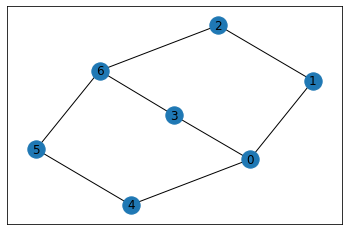

In [5]:
edges = [(0, 1), (0, 3), (0, 4), (1, 2), (2, 6), (3, 6), (4, 5), (5, 6)]
edge_map = {e: i for i, e in enumerate(edges)}
lengths = [1, 1, 1, 1, 1, 1, 1, 1]

G = nx.Graph()
for edge, length in zip(edges, lengths):
    G.add_edge(*edge, length=length)

nx.draw_networkx(G)

In [70]:
def get_path_candidates():
    start = [0, 0, 0]
    goal = [6, 6, 6]
    num_cars = len(start)
    path_num = 3

    path_map = {} # path -> index の map
    path_edges = {} # path_index -> list of edge_index の map
    car_path = {} # car_index -> list of path_index の map

    for i in range(num_cars):
        car_path[i] = []
        # 短い方から path_num 個 の経路を取ってくる
        paths = nx.shortest_simple_paths(G, source=start[i], target=goal[i], weight='length')
        _path_index = 0
        for path in paths:
            _path_tuple = tuple(path)
            path_map[_path_tuple] = path_map.get(_path_tuple, len(path_map))
            car_path[i].append(path_map[_path_tuple])
            _path_index += 1
            if _path_index >= path_num:
                break

        # 経路をエッジで表現
        for path, path_index in path_map.items():
            path_edges[path_index] = [edge_map[node, path[i+1]] for i, node in enumerate(path[:-1])]

    # Cを作成
    C = np.zeros((len(edges), len(path_map)))
    for path_index, edge_indices in path_edges.items():
        for e in edge_indices:
            C[e, path_index] = 1
    
    instance_data = {
        "C": C,
        "P": C.shape[1],
        "E": C.shape[0],
        "N": num_cars
    }
    
    return instance_data, path_map, car_path, path_edges

In [71]:
instance_data, path_map, car_path, path_edges = get_path_candidates()

In [72]:
pyq_obj = problem.to_pyqubo(instance_data)

In [73]:
qubo, _ = pyq_obj.compile().to_qubo(feed_dict={"one-car": 6})

In [74]:
import openjij as oj
sampler = oj.SASampler()
res = sampler.sample_qubo(qubo, num_reads=100)

In [75]:
decoded = problem.decode(res, instance_data)
decoded

DecodedSamples(feasibles = 100[/100], objective = 8.0, energy = -10.0)

In [79]:
x_value = decoded.solutions[2]['x']
x_value

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [86]:
path_map_inverse = {index: path for path, index in path_map.items()}
car_selected_path = [path_map_inverse[p] for i, p in enumerate(np.where(x_value == 1)[1])]

In [87]:
car_selected_path

[(0, 1, 2, 6), (0, 4, 5, 6), (0, 3, 6)]

[(0, 1), (1, 2), (2, 6)]
[(0, 4), (4, 5), (5, 6)]
[(0, 3), (3, 6)]


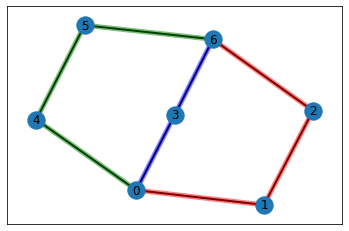

In [92]:
import matplotlib.pyplot as plt
route_colors = ['r', 'g', 'b']
pos = nx.spring_layout(G)
nx.draw_networkx(G, pos, width=2)
for car_path, color in zip(car_selected_path, route_colors):
    edge_list = [(p, car_path[i+1]) for i, p in enumerate(car_path[:-1])]
    print(edge_list)
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_color=color, alpha=0.5, width=5)
plt.show()